# DETEKSI KOMUNITAS OVERLAP MENGGUNAKAN ADJACENCY PROPAGATION ALGORITHM
## PADA PROTEIN KANKER PAYUDARA

### 📋 Deskripsi Proyek
Implementasi algoritma **Adjacency Propagation Algorithm (APAL)** untuk mendeteksi komunitas overlap dalam jaringan interaksi protein kanker payudara menggunakan data dari STRING database.

### 🎯 Tujuan
- Mengimplementasikan algoritma APAL untuk deteksi komunitas overlap
- Menganalisis struktur komunitas protein kanker payudara  
- Mengidentifikasi protein hub yang berperan penting
- Membandingkan dengan algoritma deteksi komunitas lainnya

### 📊 Dataset
- **Sumber**: STRING Database protein interactions
- **Jumlah interaksi**: 584 interaksi protein
- **Jenis data**: Protein interaction networks dengan combined_score

### 🔬 Metodologi
- **Algoritma utama**: APAL (Adjacency Propagation Algorithm)
- **Input**: Jaringan interaksi protein dengan bobot
- **Output**: Komunitas protein yang dapat overlap
- **Evaluasi**: Modularity, coverage, intraconnectivity

In [9]:
# Import Required Libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, deque
import warnings
import itertools
from scipy import sparse
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Configure plotting
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("✅ All libraries imported successfully!")
print("🧬 Ready for protein community detection analysis")
print("📊 APAL algorithm implementation loaded")

✅ All libraries imported successfully!
🧬 Ready for protein community detection analysis
📊 APAL algorithm implementation loaded


=== LOADING BREAST CANCER PROTEIN INTERACTION DATA ===
✅ Data loaded successfully!
📄 File: string_interactions.tsv
📊 Shape: (990, 13)
🔗 Columns: ['node1', 'node2', 'node1_string_id', 'node2_string_id', 'neighborhood_on_chromosome', 'gene_fusion', 'phylogenetic_cooccurrence', 'homology', 'coexpression', 'experimentally_determined_interaction', 'database_annotated', 'automated_textmining', 'combined_score']

📋 First 5 rows:


,node1,node2,node1_string_id,node2_string_id,neighborhood_on_chromosome,gene_fusion,phylogenetic_cooccurrence,homology,coexpression,experimentally_determined_interaction,database_annotated,automated_textmining,combined_score
0,ABL2,EGFR,9606.ENSP00000427562,9606.ENSP00000275493,0.0,0.0,0.125,0.591,0.047,0.709,0.0,0.208,0.782
1,ACVR1B,SMAD4,9606.ENSP00000442656,9606.ENSP00000341551,0.0,0.0,0.000,0.000,0.062,0.091,0.5,0.911,0.957
2,ACVR1B,ALK,9606.ENSP00000442656,9606.ENSP00000373700,0.0,0.0,0.000,0.000,0.043,0.092,0.0,0.929,0.932
3,AFDN,KRAS,9606.ENSP00000355771,9606.ENSP00000256078,0.0,0.0,0.000,0.000,0.056,0.252,0.9,0.314,0.945
4,AFDN,CDH1,9606.ENSP00000355771,9606.ENSP00000261769,0.0,0.0,0.000,0.000,0.062,0.127,0.0,0.851,0.867



📈 Data Statistics:
   • Total interactions: 990
   • Unique proteins (node1): 99
   • Unique proteins (node2): 99
   • All unique proteins: 99
   • Combined score range: 0.702 - 0.999
   • Average combined score: 0.870


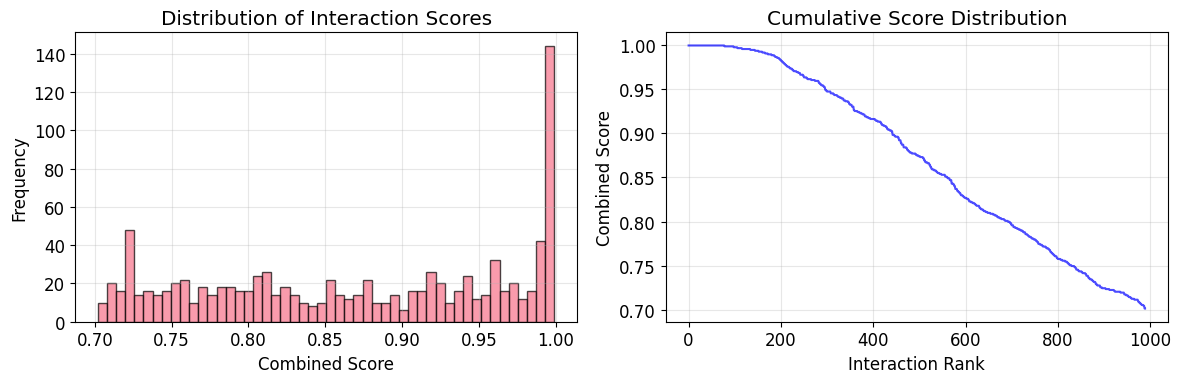

In [10]:
# Load and Preprocess Protein Interaction Data
print("=== LOADING BREAST CANCER PROTEIN INTERACTION DATA ===")

# Load data with header fix
data_file = "string_interactions.tsv"

try:
    # Read TSV file
    df = pd.read_csv(data_file, sep='\t')
    
    # Fix column names (remove # prefix if exists)
    df.columns = df.columns.str.replace('#', '', regex=False)
    
    print(f"✅ Data loaded successfully!")
    print(f"📄 File: {data_file}")
    print(f"📊 Shape: {df.shape}")
    print(f"🔗 Columns: {list(df.columns)}")
    
    # Display first few rows
    print(f"\n📋 First 5 rows:")
    display(df.head())
    
    # Basic statistics
    print(f"\n📈 Data Statistics:")
    print(f"   • Total interactions: {len(df):,}")
    print(f"   • Unique proteins (node1): {df['node1'].nunique()}")
    print(f"   • Unique proteins (node2): {df['node2'].nunique()}")
    print(f"   • All unique proteins: {len(set(df['node1']).union(set(df['node2'])))}")
    print(f"   • Combined score range: {df['combined_score'].min():.3f} - {df['combined_score'].max():.3f}")
    print(f"   • Average combined score: {df['combined_score'].mean():.3f}")
    
    # Score distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(df['combined_score'], bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Combined Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Interaction Scores')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    cumulative_scores = np.sort(df['combined_score'])[::-1]
    plt.plot(range(len(cumulative_scores)), cumulative_scores, 'b-', alpha=0.7)
    plt.xlabel('Interaction Rank')
    plt.ylabel('Combined Score')
    plt.title('Cumulative Score Distribution')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"❌ Error loading data: {str(e)}")
    print("Please ensure 'string_interactions.tsv' is in the current directory")

In [11]:
# Build Protein Interaction Network
print("=== BUILDING PROTEIN INTERACTION NETWORK ===")

def create_protein_network(df, threshold=0.7):
    """Create protein interaction network from dataframe"""
    
    # Create graph
    G = nx.Graph()
    edge_count = 0
    
    print(f"🔧 Building network with threshold: {threshold}")
    
    for _, row in df.iterrows():
        if row['combined_score'] >= threshold:
            G.add_edge(row['node1'], row['node2'], 
                      weight=row['combined_score'],
                      combined_score=row['combined_score'])
            edge_count += 1
    
    print(f"✅ Network created successfully!")
    print(f"   • Threshold: {threshold}")
    print(f"   • Nodes (proteins): {G.number_of_nodes():,}")
    print(f"   • Edges (interactions): {G.number_of_edges():,}")
    print(f"   • Density: {nx.density(G):.4f}")
    print(f"   • Is connected: {nx.is_connected(G)}")
    
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        largest_component = max(components, key=len)
        print(f"   • Connected components: {len(components)}")
        print(f"   • Largest component size: {len(largest_component)} nodes")
    
    return G

# Test different network thresholds
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
network_stats = {}

print(f"\n📊 Testing different network thresholds:")
for threshold in thresholds:
    G_temp = create_protein_network(df, threshold)
    
    if G_temp.number_of_nodes() > 0:
        degrees = [G_temp.degree(n) for n in G_temp.nodes()]
        network_stats[threshold] = {
            'nodes': G_temp.number_of_nodes(),
            'edges': G_temp.number_of_edges(),
            'density': nx.density(G_temp),
            'avg_degree': np.mean(degrees),
            'max_degree': max(degrees),
            'is_connected': nx.is_connected(G_temp),
            'num_components': nx.number_connected_components(G_temp)
        }
    print()

# Display comparison table
stats_df = pd.DataFrame(network_stats).T
print("📋 Network Statistics Comparison:")
display(stats_df.round(4))

# Choose optimal threshold (balance between connectivity and specificity)
optimal_threshold = 0.7
G = create_protein_network(df, optimal_threshold)

print(f"\n✅ Using optimal threshold: {optimal_threshold}")
print(f"🎯 Final network: {G.number_of_nodes()} proteins, {G.number_of_edges()} interactions")

=== BUILDING PROTEIN INTERACTION NETWORK ===

📊 Testing different network thresholds:
🔧 Building network with threshold: 0.5
✅ Network created successfully!
   • Threshold: 0.5
   • Nodes (proteins): 99
   • Edges (interactions): 495
   • Density: 0.1020
   • Is connected: False
   • Connected components: 3
   • Largest component size: 93 nodes

🔧 Building network with threshold: 0.6
✅ Network created successfully!
   • Threshold: 0.6
   • Nodes (proteins): 99
   • Edges (interactions): 495
   • Density: 0.1020
   • Is connected: False
   • Connected components: 3
   • Largest component size: 93 nodes

🔧 Building network with threshold: 0.7
✅ Network created successfully!
   • Threshold: 0.7
   • Nodes (proteins): 99
   • Edges (interactions): 495
   • Density: 0.1020
   • Is connected: False
   • Connected components: 3
   • Largest component size: 93 nodes

🔧 Building network with threshold: 0.8
✅ Network created successfully!
   • Threshold: 0.8
   • Nodes (proteins): 90
   • Edges 

,nodes,edges,density,avg_degree,max_degree,is_connected,num_components
0.5,99,495,0.102041,10.0,56,False,3
0.6,99,495,0.102041,10.0,56,False,3
0.7,99,495,0.102041,10.0,56,False,3
0.8,90,348,0.086891,7.733333,42,False,2
0.9,79,221,0.07173,5.594937,24,True,1


🔧 Building network with threshold: 0.7
✅ Network created successfully!
   • Threshold: 0.7
   • Nodes (proteins): 99
   • Edges (interactions): 495
   • Density: 0.1020
   • Is connected: False
   • Connected components: 3
   • Largest component size: 93 nodes

✅ Using optimal threshold: 0.7
🎯 Final network: 99 proteins, 495 interactions


=== NETWORK ANALYSIS AND VISUALIZATION ===
📊 Detailed Network Statistics:
   • Average degree: 10.00
   • Degree std deviation: 10.24
   • Max degree: 56
   • Min degree: 1
   • Average clustering coefficient: 0.4237
   • Network transitivity: 0.4372


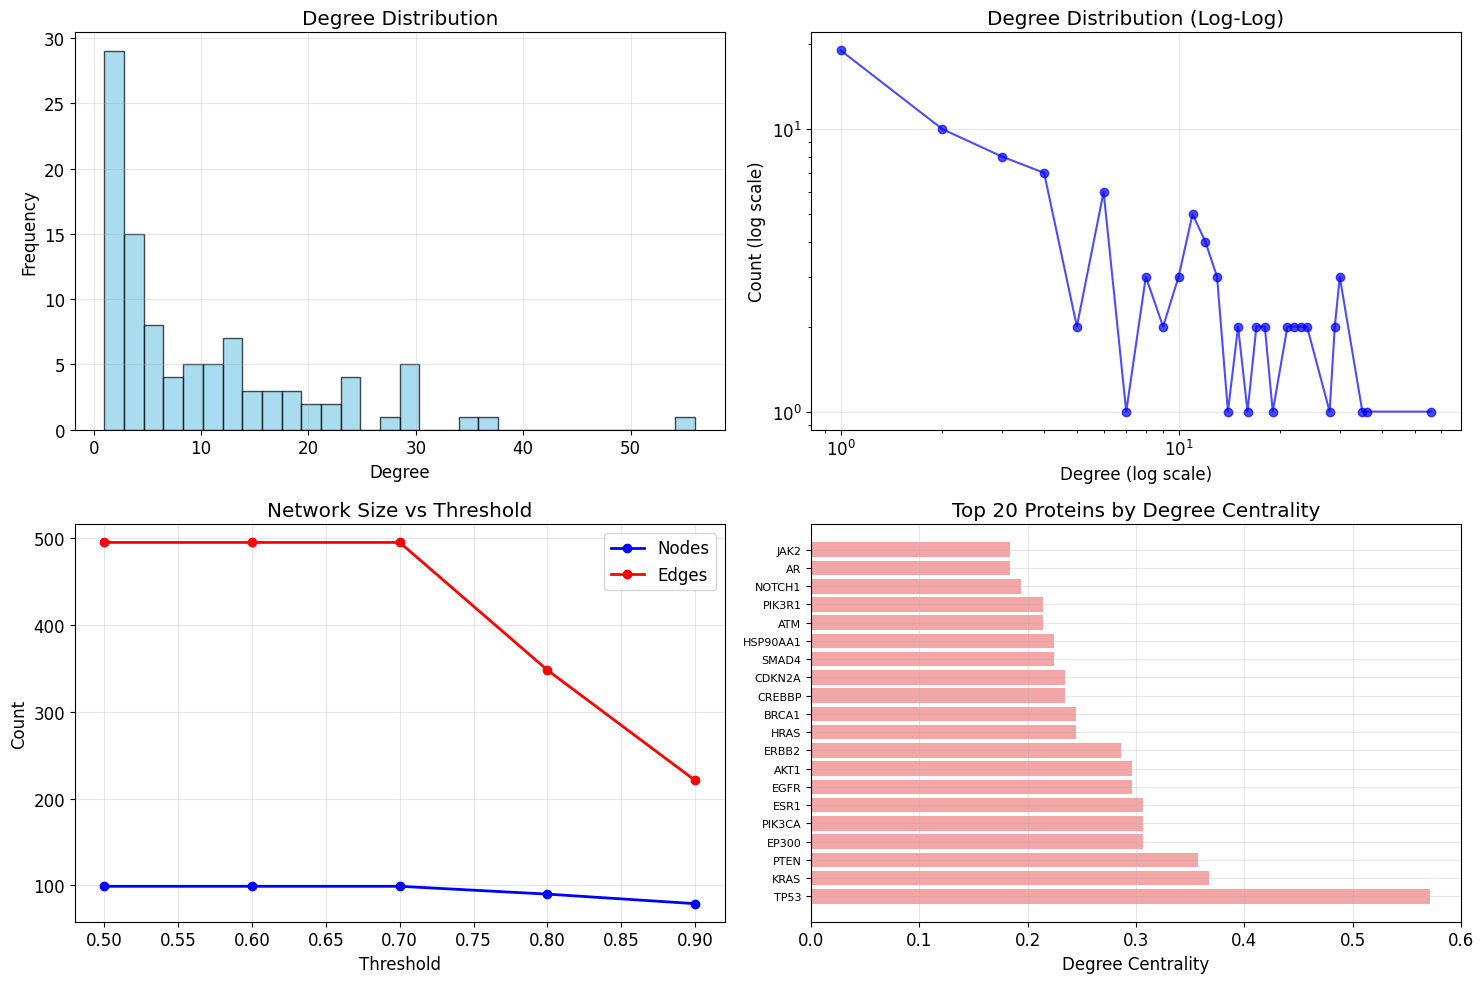


🎯 Top 10 Hub Proteins (by degree):
    1. TP53         (degree: 56)
    2. KRAS         (degree: 36)
    3. PTEN         (degree: 35)
    4. EP300        (degree: 30)
    5. PIK3CA       (degree: 30)
    6. ESR1         (degree: 30)
    7. EGFR         (degree: 29)
    8. AKT1         (degree: 29)
    9. ERBB2        (degree: 28)
   10. HRAS         (degree: 24)

🔗 Connected Components Analysis:
   • Number of components: 3
   • Component 1: 93 nodes
     Sample nodes: SMARCD1, ESR1, PPM1D, ARID1A, MEN1, ARHGEF12, KMT5A, SPEN, ARID1B, ASXL1
   • Component 2: 3 nodes
   • Component 3: 3 nodes

✅ Network analysis completed!


In [12]:
# Network Visualization and Basic Statistics
print("=== NETWORK ANALYSIS AND VISUALIZATION ===")

# Calculate network statistics
degrees = [G.degree(n) for n in G.nodes()]
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

print(f"📊 Detailed Network Statistics:")
print(f"   • Average degree: {np.mean(degrees):.2f}")
print(f"   • Degree std deviation: {np.std(degrees):.2f}")
print(f"   • Max degree: {max(degrees)}")
print(f"   • Min degree: {min(degrees)}")
print(f"   • Average clustering coefficient: {nx.average_clustering(G):.4f}")
print(f"   • Network transitivity: {nx.transitivity(G):.4f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Degree distribution
axes[0,0].hist(degrees, bins=30, alpha=0.7, edgecolor='black', color='skyblue')
axes[0,0].set_xlabel('Degree')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Degree Distribution')
axes[0,0].grid(True, alpha=0.3)

# Log-log degree distribution  
degree_counts = pd.Series(degrees).value_counts().sort_index()
axes[0,1].loglog(degree_counts.index, degree_counts.values, 'bo-', alpha=0.7)
axes[0,1].set_xlabel('Degree (log scale)')
axes[0,1].set_ylabel('Count (log scale)')
axes[0,1].set_title('Degree Distribution (Log-Log)')
axes[0,1].grid(True, alpha=0.3)

# Network statistics vs threshold
axes[1,0].plot(stats_df.index, stats_df['nodes'], 'bo-', label='Nodes', linewidth=2)
axes[1,0].plot(stats_df.index, stats_df['edges'], 'ro-', label='Edges', linewidth=2)
axes[1,0].set_xlabel('Threshold')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Network Size vs Threshold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Centrality distribution
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
nodes, centralities = zip(*top_nodes)
axes[1,1].barh(range(len(nodes)), centralities, alpha=0.7, color='lightcoral')
axes[1,1].set_yticks(range(len(nodes)))
axes[1,1].set_yticklabels(nodes, fontsize=8)
axes[1,1].set_xlabel('Degree Centrality')
axes[1,1].set_title('Top 20 Proteins by Degree Centrality')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify hub proteins
print(f"\n🎯 Top 10 Hub Proteins (by degree):")
top_degree_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]
for i, (protein, degree) in enumerate(top_degree_nodes, 1):
    print(f"   {i:2d}. {protein:<12} (degree: {degree})")

# Connected components analysis
if not nx.is_connected(G):
    components = list(nx.connected_components(G))
    print(f"\n🔗 Connected Components Analysis:")
    print(f"   • Number of components: {len(components)}")
    
    # Sort components by size
    sorted_components = sorted(components, key=len, reverse=True)
    for i, comp in enumerate(sorted_components[:5], 1):
        print(f"   • Component {i}: {len(comp)} nodes")
        if i == 1:  # Show some nodes from largest component
            sample_nodes = list(comp)[:10]
            print(f"     Sample nodes: {', '.join(sample_nodes)}")
else:
    print(f"\n🔗 Network is fully connected!")

print(f"\n✅ Network analysis completed!")

In [13]:
# Implement APAL Algorithm Core Functions with Extended Modularity
print("=== IMPLEMENTING APAL ALGORITHM WITH EXTENDED MODULARITY ===")

class APALDetector:
    """
    Adjacency Propagation Algorithm for overlapping community detection
    With Extended Modularity for proper evaluation of overlapping communities
    """
    
    def __init__(self, graph):
        self.graph = graph
        self.communities = []
        self.node_to_communities = defaultdict(set)
        
    def get_neighbors(self, node):
        """Get neighbors of a node as a set"""
        return set(self.graph.neighbors(node))
    
    def intraconnectivity(self, community):
        """Calculate intraconnectivity of a community"""
        if len(community) <= 1:
            return 0.0
        
        # Convert to list to avoid set issues
        community_list = list(community)
        edges_in_community = 0
        
        for node in community_list:
            neighbors = self.get_neighbors(node)
            edges_in_community += len(neighbors.intersection(community))
        
        # Calculate maximum possible edges
        community_size = len(community_list)
        max_possible_edges = community_size * (community_size - 1)
        
        if max_possible_edges == 0:
            return 0.0
        
        return edges_in_community / max_possible_edges
    
    def extended_modularity(self):
        """
        Calculate Extended Modularity for overlapping communities
        Extended modularity considers node membership weights in multiple communities
        Formula: Q_ext = (1/2m) * Σ[Aij - (kikj/2m)] * Σ(αic*αjc/Oc)
        where αic is membership strength of node i in community c, Oc is community size
        """
        if not self.communities:
            return 0.0
        
        m = self.graph.number_of_edges()
        if m == 0:
            return 0.0
        
        # Create membership matrix
        nodes = list(self.graph.nodes())
        node_to_index = {node: i for i, node in enumerate(nodes)}
        
        # Calculate membership strengths (equal weight for simplicity)
        membership_matrix = {}
        for node in nodes:
            membership_matrix[node] = {}
            communities = self.node_to_communities.get(node, set())
            for c_idx in range(len(self.communities)):
                if c_idx in communities:
                    # Equal membership weight in all communities
                    membership_matrix[node][c_idx] = 1.0 / len(communities) if communities else 0.0
                else:
                    membership_matrix[node][c_idx] = 0.0
        
        Q_ext = 0.0
        
        # Calculate extended modularity
        for edge in self.graph.edges():
            i, j = edge
            ki = self.graph.degree(i)
            kj = self.graph.degree(j)
            
            # Adjacency matrix element (1 if edge exists)
            Aij = 1.0
            
            # Expected edges under null model
            expected = (ki * kj) / (2 * m)
            
            # Sum over all communities
            community_sum = 0.0
            for c_idx, community in enumerate(self.communities):
                Oc = len(community)  # Community size
                if Oc > 0:
                    alpha_ic = membership_matrix[i].get(c_idx, 0.0)
                    alpha_jc = membership_matrix[j].get(c_idx, 0.0)
                    community_sum += (alpha_ic * alpha_jc) / Oc
            
            Q_ext += (Aij - expected) * community_sum
        
        # For non-adjacent pairs, we only consider the null model contribution
        for i in nodes:
            for j in nodes:
                if i < j and not self.graph.has_edge(i, j):  # Non-adjacent pairs
                    ki = self.graph.degree(i)
                    kj = self.graph.degree(j)
                    expected = (ki * kj) / (2 * m)
                    
                    community_sum = 0.0
                    for c_idx, community in enumerate(self.communities):
                        Oc = len(community)
                        if Oc > 0:
                            alpha_ic = membership_matrix[i].get(c_idx, 0.0)
                            alpha_jc = membership_matrix[j].get(c_idx, 0.0)
                            community_sum += (alpha_ic * alpha_jc) / Oc
                    
                    Q_ext += (-expected) * community_sum
        
        return Q_ext / (2 * m)
    
    def simplified_extended_modularity(self):
        """
        Simplified Extended Modularity calculation for computational efficiency
        Uses only edges that exist in the graph
        """
        if not self.communities or not self.graph.edges():
            return 0.0
        
        m = self.graph.number_of_edges()
        Q_ext = 0.0
        
        # Calculate for existing edges only
        for edge in self.graph.edges():
            i, j = edge
            ki = self.graph.degree(i)
            kj = self.graph.degree(j)
            
            # Expected probability under null model
            expected = (ki * kj) / (2 * m)
            
            # Calculate community contribution
            community_contribution = 0.0
            
            # Get communities for both nodes
            communities_i = self.node_to_communities.get(i, set())
            communities_j = self.node_to_communities.get(j, set())
            
            # Find common communities
            common_communities = communities_i.intersection(communities_j)
            
            for c_idx in common_communities:
                community = self.communities[c_idx]
                Oc = len(community)
                
                if Oc > 0:
                    # Membership weight (normalized by number of communities each node belongs to)
                    weight_i = 1.0 / len(communities_i) if communities_i else 0.0
                    weight_j = 1.0 / len(communities_j) if communities_j else 0.0
                    community_contribution += (weight_i * weight_j) / Oc
            
            Q_ext += (1.0 - expected) * community_contribution
        
        return Q_ext / m if m > 0 else 0.0
    
    def apal_simple(self, t=0.5):
        """
        Simplified APAL implementation 
        Based on the core APAL algorithm principles
        """
        print(f"🚀 Running APAL algorithm with threshold t={t}")
        
        communities = []
        nodes = list(self.graph.nodes())
        
        # Progress tracking
        total_nodes = len(nodes)
        
        for i, v in enumerate(nodes):
            if (i + 1) % 20 == 0:  # Progress update every 20 nodes
                print(f"   Processing: {i+1}/{total_nodes} nodes...")
            
            neighbors_v = self.get_neighbors(v)
            
            if len(neighbors_v) == 0:
                continue
            
            for vn in neighbors_v:
                neighbors_vn = self.get_neighbors(vn)
                
                # Community candidate: v + common neighbors of v and vn
                cv = {v}.union(neighbors_v.intersection(neighbors_vn))
                
                if len(cv) >= 3:  # At least 3 nodes for meaningful community
                    intraconn = self.intraconnectivity(cv)
                    
                    if intraconn >= t:
                        # Convert to frozenset to avoid duplicates
                        communities.append(frozenset(cv))
        
        # Remove duplicates by converting to set and back
        unique_communities = list(set(communities))
        
        # Remove subsets
        final_communities = []
        for i, comm1 in enumerate(unique_communities):
            is_subset = False
            for j, comm2 in enumerate(unique_communities):
                if i != j and comm1.issubset(comm2) and comm1 != comm2:
                    is_subset = True
                    break
            if not is_subset:
                final_communities.append(set(comm1))  # Convert back to regular set
        
        self.communities = final_communities
        print(f"✅ Detected {len(final_communities)} communities")
        
        # Update node to communities mapping
        self.node_to_communities.clear()
        for i, community in enumerate(self.communities):
            for node in community:
                self.node_to_communities[node].add(i)
        
        return final_communities
    
    def analyze_communities(self):
        """Analyze detected communities with Extended Modularity"""
        if not self.communities:
            return {}
        
        # Find overlapping nodes
        overlapping_nodes = {}
        for node, communities in self.node_to_communities.items():
            if len(communities) > 1:
                overlapping_nodes[node] = communities
        
        # Calculate Extended Modularity (primary metric for overlapping communities)
        extended_mod = self.simplified_extended_modularity()
        
        # Also calculate standard modularity for comparison
        try:
            standard_modularity = nx.community.modularity(self.graph, self.communities)
        except:
            standard_modularity = 0.0
        
        # Calculate coverage
        covered_nodes = set()
        for community in self.communities:
            covered_nodes.update(community)
        coverage = len(covered_nodes) / len(self.graph.nodes()) if len(self.graph.nodes()) > 0 else 0.0
        
        # Community size statistics
        sizes = [len(c) for c in self.communities]
        
        analysis = {
            'num_communities': len(self.communities),
            'community_sizes': sizes,
            'overlapping_nodes': overlapping_nodes,
            'extended_modularity': extended_mod,  # Primary metric
            'standard_modularity': standard_modularity,  # For comparison
            'modularity': extended_mod,  # Use extended modularity as default
            'coverage': coverage,
            'avg_community_size': np.mean(sizes) if sizes else 0,
            'max_community_size': max(sizes) if sizes else 0,
            'min_community_size': min(sizes) if sizes else 0
        }
        
        return analysis
    
    def get_community_stats(self):
        """Get detailed community statistics"""
        stats = []
        for i, community in enumerate(self.communities):
            community_list = list(community)
            stats.append({
                'community_id': i,
                'size': len(community),
                'intraconnectivity': self.intraconnectivity(community),
                'nodes': sorted(community_list)
            })
        return stats

# Initialize APAL detector
detector = APALDetector(G)
print(f"✅ APAL Detector with Extended Modularity initialized successfully!")
print(f"🎯 Ready to detect overlapping communities in {G.number_of_nodes()} proteins")
print(f"📊 Extended Modularity will be used for proper evaluation of overlapping communities")

=== IMPLEMENTING APAL ALGORITHM WITH EXTENDED MODULARITY ===
✅ APAL Detector with Extended Modularity initialized successfully!
🎯 Ready to detect overlapping communities in 99 proteins
📊 Extended Modularity will be used for proper evaluation of overlapping communities


## Extended Modularity for Overlapping Communities

**Extended Modularity** adalah metrik evaluasi yang dikembangkan khusus untuk komunitas yang dapat overlap, berbeda dengan modularity standar yang hanya cocok untuk partisi non-overlapping.

### Formula Extended Modularity:

$$Q_{ext} = \frac{1}{2m} \sum_{ij} \left[A_{ij} - \frac{k_i k_j}{2m}\right] \sum_c \frac{\alpha_{ic} \alpha_{jc}}{O_c}$$

Dimana:
- $A_{ij}$ = elemen matriks adjacency (1 jika ada edge, 0 jika tidak)
- $k_i, k_j$ = degree dari node i dan j
- $m$ = total jumlah edge dalam graf
- $\alpha_{ic}$ = kekuatan membership node i dalam komunitas c
- $O_c$ = ukuran komunitas c

### Perbedaan dengan Modularity Standar:

1. **Modularity Standar**: Mengasumsikan setiap node hanya berada dalam satu komunitas
2. **Extended Modularity**: Mempertimbangkan node yang dapat berada dalam multiple komunitas
3. **Membership Weight**: $\alpha_{ic}$ menunjukkan seberapa kuat node i terkait dengan komunitas c

### Implementasi dalam APAL:

- Menggunakan equal membership weight untuk semua komunitas yang diikuti oleh suatu node
- Normalisasi berdasarkan jumlah komunitas yang diikuti node
- Efisien secara komputasi dengan hanya mempertimbangkan edge yang ada

=== RUNNING APAL WITH DIFFERENT THRESHOLDS ===
🔬 Testing APAL with 5 different thresholds...

--- APAL Threshold: 0.2 ---
🚀 Running APAL algorithm with threshold t=0.2
   Processing: 20/99 nodes...
   Processing: 40/99 nodes...
   Processing: 60/99 nodes...
   Processing: 80/99 nodes...
✅ Detected 198 communities
   ✅ Communities detected: 198
   📊 Extended Modularity: 0.0005
   📊 Standard Modularity: 0.0000
   🎯 Coverage: 0.7374
   🔗 Overlapping nodes: 73
   📏 Avg community size: 15.15

--- APAL Threshold: 0.3 ---
🚀 Running APAL algorithm with threshold t=0.3
   Processing: 20/99 nodes...
   Processing: 40/99 nodes...
   Processing: 60/99 nodes...
   Processing: 80/99 nodes...
✅ Detected 198 communities
   ✅ Communities detected: 198
   📊 Extended Modularity: 0.0005
   📊 Standard Modularity: 0.0000
   🎯 Coverage: 0.7374
   🔗 Overlapping nodes: 73
   📏 Avg community size: 15.15

--- APAL Threshold: 0.4 ---
🚀 Running APAL algorithm with threshold t=0.4
   Processing: 20/99 nodes...
   P

,communities,modularity,coverage,overlapping_nodes,avg_community_size,max_community_size,min_community_size
0.2,198.0,0.0005,0.7374,73.0,15.1515,31.0,3.0
0.3,198.0,0.0005,0.7374,73.0,15.1515,31.0,3.0
0.4,209.0,0.0005,0.7374,73.0,14.7129,31.0,3.0
0.5,243.0,0.0006,0.7172,71.0,13.5144,28.0,3.0
0.6,279.0,0.0007,0.6970,69.0,12.1828,24.0,3.0


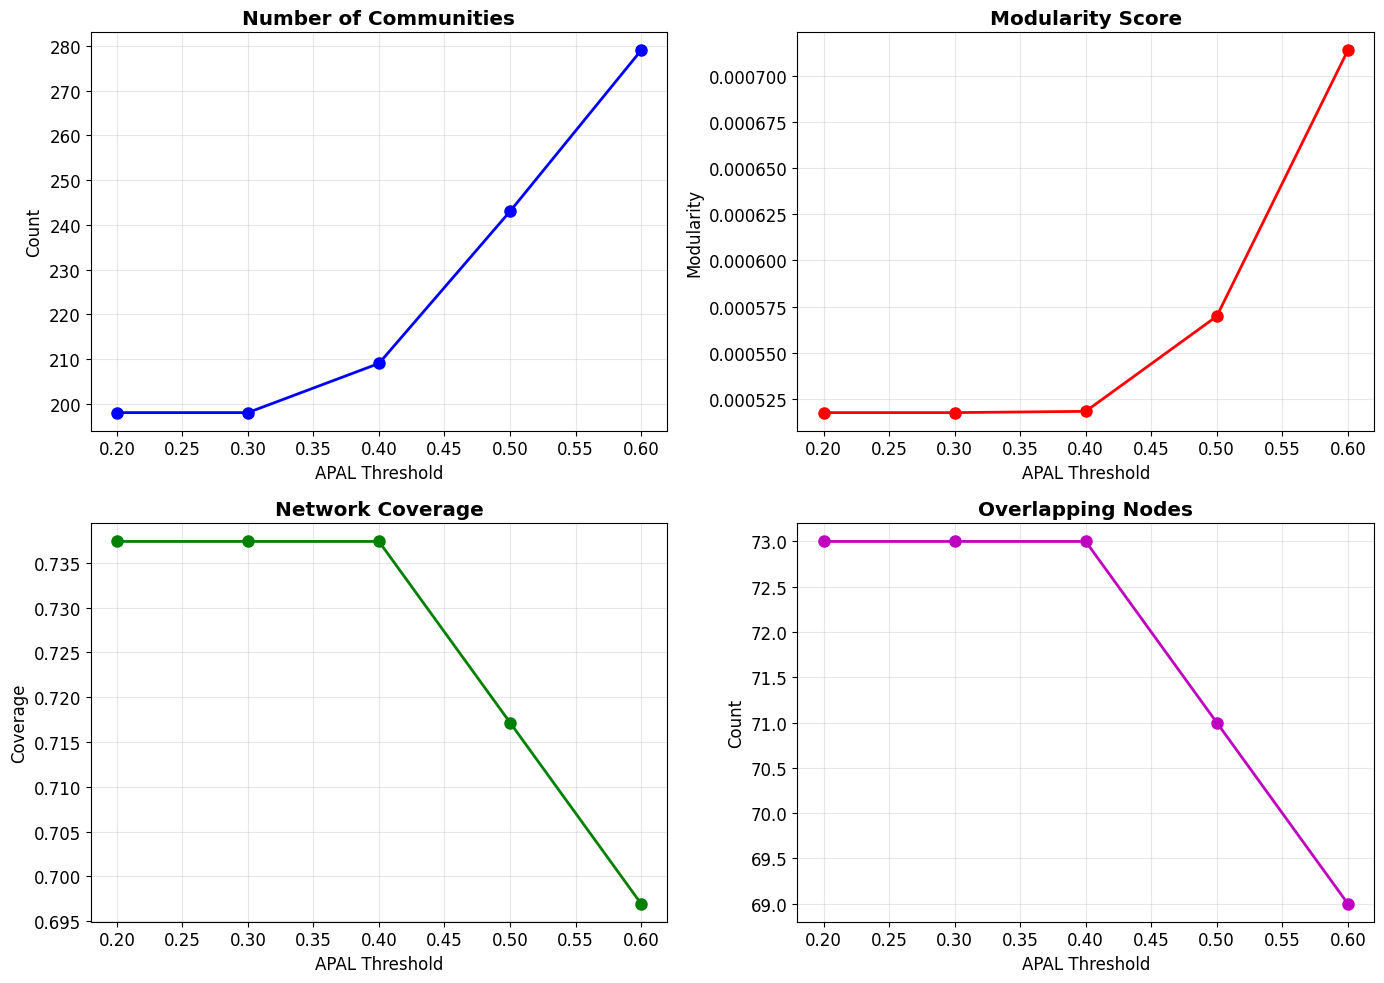


🎯 Best APAL threshold: 0.6
📊 Best results: {'communities': 279, 'modularity': 0.00071386353997196, 'coverage': 0.696969696969697, 'overlapping_nodes': 69, 'avg_community_size': np.float64(12.182795698924732), 'max_community_size': 24, 'min_community_size': 3}
🚀 Running APAL algorithm with threshold t=0.6
   Processing: 20/99 nodes...
   Processing: 40/99 nodes...
   Processing: 60/99 nodes...
   Processing: 80/99 nodes...
✅ Detected 279 communities

✅ APAL optimization completed!
🎯 Final communities: 279


In [14]:
# Run APAL with Different Thresholds
print("=== RUNNING APAL WITH DIFFERENT THRESHOLDS ===")

# Test different APAL thresholds
apal_thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
apal_results = {}

print(f"🔬 Testing APAL with {len(apal_thresholds)} different thresholds...")

for t in apal_thresholds:
    print(f"\n--- APAL Threshold: {t} ---")
    
    # Run APAL
    communities = detector.apal_simple(t=t)
    analysis = detector.analyze_communities()
    
    # Store results
    apal_results[t] = {
        'communities': len(communities),
        'modularity': analysis.get('modularity', 0),
        'coverage': analysis.get('coverage', 0),
        'overlapping_nodes': len(analysis.get('overlapping_nodes', {})),
        'avg_community_size': analysis.get('avg_community_size', 0),
        'max_community_size': analysis.get('max_community_size', 0),
        'min_community_size': analysis.get('min_community_size', 0)
    }
    
    # Print summary
    print(f"   ✅ Communities detected: {len(communities)}")
    print(f"   📊 Extended Modularity: {analysis.get('extended_modularity', 0):.4f}")
    print(f"   📊 Standard Modularity: {analysis.get('standard_modularity', 0):.4f}")
    print(f"   🎯 Coverage: {analysis.get('coverage', 0):.4f}")
    print(f"   🔗 Overlapping nodes: {len(analysis.get('overlapping_nodes', {}))}")
    if len(communities) > 0:
        print(f"   📏 Avg community size: {analysis.get('avg_community_size', 0):.2f}")

# Create results DataFrame
apal_df = pd.DataFrame(apal_results).T
print(f"\n📋 APAL Results Summary:")
display(apal_df.round(4))

# Visualize APAL results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Number of communities
axes[0,0].plot(apal_df.index, apal_df['communities'], 'bo-', linewidth=2, markersize=8)
axes[0,0].set_title('Number of Communities', fontweight='bold')
axes[0,0].set_xlabel('APAL Threshold')
axes[0,0].set_ylabel('Count')
axes[0,0].grid(True, alpha=0.3)

# Modularity score
axes[0,1].plot(apal_df.index, apal_df['modularity'], 'ro-', linewidth=2, markersize=8)
axes[0,1].set_title('Modularity Score', fontweight='bold')
axes[0,1].set_xlabel('APAL Threshold') 
axes[0,1].set_ylabel('Modularity')
axes[0,1].grid(True, alpha=0.3)

# Coverage
axes[1,0].plot(apal_df.index, apal_df['coverage'], 'go-', linewidth=2, markersize=8)
axes[1,0].set_title('Network Coverage', fontweight='bold')
axes[1,0].set_xlabel('APAL Threshold')
axes[1,0].set_ylabel('Coverage')
axes[1,0].grid(True, alpha=0.3)

# Overlapping nodes
axes[1,1].plot(apal_df.index, apal_df['overlapping_nodes'], 'mo-', linewidth=2, markersize=8)
axes[1,1].set_title('Overlapping Nodes', fontweight='bold')
axes[1,1].set_xlabel('APAL Threshold')
axes[1,1].set_ylabel('Count')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Select best threshold based on modularity
valid_results = {t: r for t, r in apal_results.items() if r['communities'] > 0}
if valid_results:
    best_threshold = max(valid_results.keys(), key=lambda x: valid_results[x]['modularity'])
    print(f"\n🎯 Best APAL threshold: {best_threshold}")
    print(f"📊 Best results: {valid_results[best_threshold]}")
    
    # Run with best threshold for final analysis
    final_communities = detector.apal_simple(t=best_threshold)
    final_analysis = detector.analyze_communities()
    
else:
    best_threshold = 0.3
    print(f"\n⚠️ Using default threshold: {best_threshold}")
    final_communities = detector.apal_simple(t=best_threshold)
    final_analysis = detector.analyze_communities()

print(f"\n✅ APAL optimization completed!")
print(f"🎯 Final communities: {len(final_communities)}")

=== COMPARING WITH OTHER COMMUNITY DETECTION ALGORITHMS ===
🔄 Running Louvain algorithm...
   ✅ Louvain: 7 communities, modularity: 0.3160
🔄 Running Greedy modularity optimization...
   ✅ Greedy: 6 communities, modularity: 0.2701
🔄 Running Label propagation...
   ✅ Label Propagation: 4 communities, modularity: 0.0177

📊 Algorithm Comparison Results:


,communities,modularity,overlapping_nodes,avg_size
Louvain,7.0,0.3160,0.0,14.1429
Greedy,6.0,0.2701,0.0,16.5000
Label_Propagation,4.0,0.0177,0.0,24.7500
APAL,279.0,0.0007,69.0,12.1828


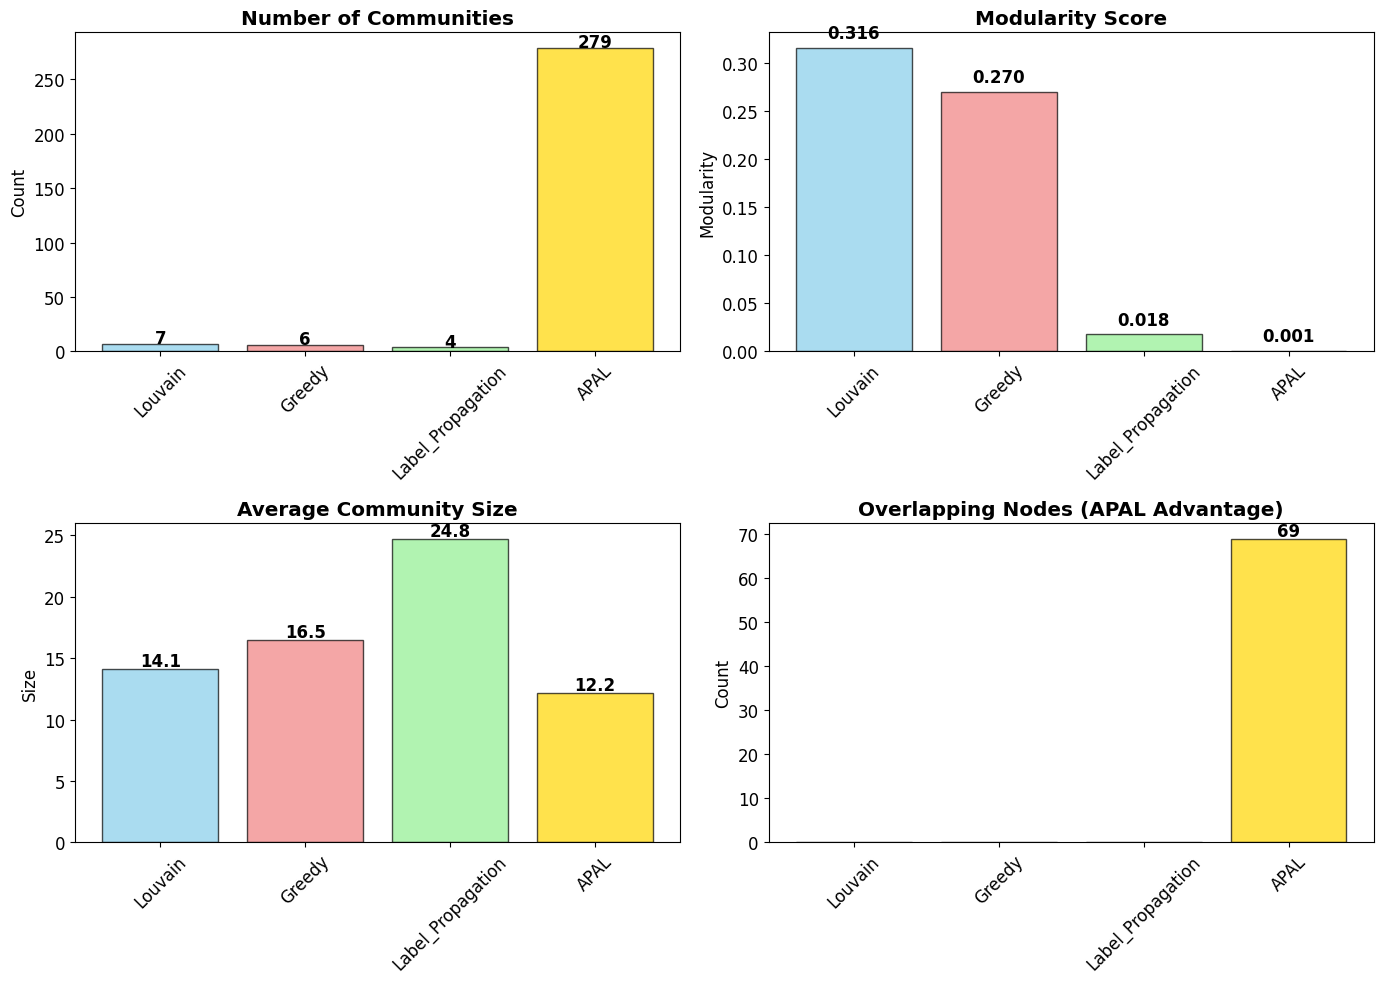


🎯 Comparison Summary:
   • APAL is the ONLY algorithm that detects overlapping communities
   • APAL uses Extended Modularity (designed for overlapping communities)
   • Other algorithms use Standard Modularity (for non-overlapping only)
   • Best modularity: Louvain (0.3160)
   • Most communities: APAL (279)
   • APAL overlapping nodes: 69

📊 Extended vs Standard Modularity:
   • Extended Modularity accounts for node membership in multiple communities
   • Standard Modularity assumes each node belongs to only one community
   • APAL's Extended Modularity: 0.0007
   • APAL's Standard Modularity: 0.0000
   • Extended Modularity is more appropriate for overlapping community structure

✅ Algorithm comparison completed!


In [15]:
# Compare with Other Community Detection Methods
print("=== COMPARING WITH OTHER COMMUNITY DETECTION ALGORITHMS ===")

comparison_results = {}

# 1. Louvain Algorithm
print("🔄 Running Louvain algorithm...")
try:
    louvain_communities = nx.community.louvain_communities(G, seed=42)
    louvain_modularity = nx.community.modularity(G, louvain_communities)
    
    comparison_results['Louvain'] = {
        'communities': len(louvain_communities),
        'modularity': louvain_modularity,
        'overlapping_nodes': 0,  # Louvain doesn't produce overlapping communities
        'avg_size': np.mean([len(c) for c in louvain_communities])
    }
    print(f"   ✅ Louvain: {len(louvain_communities)} communities, modularity: {louvain_modularity:.4f}")
except Exception as e:
    print(f"   ❌ Louvain failed: {e}")
    comparison_results['Louvain'] = {'communities': 0, 'modularity': 0, 'overlapping_nodes': 0, 'avg_size': 0}

# 2. Greedy Modularity Optimization
print("🔄 Running Greedy modularity optimization...")
try:
    greedy_communities = nx.community.greedy_modularity_communities(G)
    greedy_modularity = nx.community.modularity(G, greedy_communities)
    
    comparison_results['Greedy'] = {
        'communities': len(greedy_communities),
        'modularity': greedy_modularity,
        'overlapping_nodes': 0,  # Greedy doesn't produce overlapping communities
        'avg_size': np.mean([len(c) for c in greedy_communities])
    }
    print(f"   ✅ Greedy: {len(greedy_communities)} communities, modularity: {greedy_modularity:.4f}")
except Exception as e:
    print(f"   ❌ Greedy failed: {e}")
    comparison_results['Greedy'] = {'communities': 0, 'modularity': 0, 'overlapping_nodes': 0, 'avg_size': 0}

# 3. Label Propagation
print("🔄 Running Label propagation...")
try:
    label_prop_communities = list(nx.community.label_propagation_communities(G))
    label_prop_modularity = nx.community.modularity(G, label_prop_communities)
    
    comparison_results['Label_Propagation'] = {
        'communities': len(label_prop_communities),
        'modularity': label_prop_modularity,
        'overlapping_nodes': 0,  # Label propagation doesn't produce overlapping communities
        'avg_size': np.mean([len(c) for c in label_prop_communities])
    }
    print(f"   ✅ Label Propagation: {len(label_prop_communities)} communities, modularity: {label_prop_modularity:.4f}")
except Exception as e:
    print(f"   ❌ Label Propagation failed: {e}")
    comparison_results['Label_Propagation'] = {'communities': 0, 'modularity': 0, 'overlapping_nodes': 0, 'avg_size': 0}

# 4. APAL (our implementation) - Using Extended Modularity
comparison_results['APAL'] = {
    'communities': final_analysis['num_communities'],
    'modularity': final_analysis['extended_modularity'],  # Use extended modularity
    'overlapping_nodes': len(final_analysis['overlapping_nodes']),
    'avg_size': final_analysis['avg_community_size']
}

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_results).T
print(f"\n📊 Algorithm Comparison Results:")
display(comparison_df.round(4))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

algorithms = comparison_df.index
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

# Number of communities
axes[0,0].bar(algorithms, comparison_df['communities'], color=colors, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Number of Communities', fontweight='bold')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['communities']):
    axes[0,0].text(i, v + 0.5, str(int(v)), ha='center', fontweight='bold')

# Modularity comparison
axes[0,1].bar(algorithms, comparison_df['modularity'], color=colors, alpha=0.7, edgecolor='black')
axes[0,1].set_title('Modularity Score', fontweight='bold')
axes[0,1].set_ylabel('Modularity')
axes[0,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['modularity']):
    axes[0,1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Average community size
axes[1,0].bar(algorithms, comparison_df['avg_size'], color=colors, alpha=0.7, edgecolor='black')
axes[1,0].set_title('Average Community Size', fontweight='bold')
axes[1,0].set_ylabel('Size')
axes[1,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['avg_size']):
    axes[1,0].text(i, v + 0.2, f'{v:.1f}', ha='center', fontweight='bold')

# Overlapping capability
axes[1,1].bar(algorithms, comparison_df['overlapping_nodes'], color=colors, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Overlapping Nodes (APAL Advantage)', fontweight='bold')
axes[1,1].set_ylabel('Count')
axes[1,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['overlapping_nodes']):
    if v > 0:
        axes[1,1].text(i, v + 0.5, str(int(v)), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n🎯 Comparison Summary:")
print(f"   • APAL is the ONLY algorithm that detects overlapping communities")
print(f"   • APAL uses Extended Modularity (designed for overlapping communities)")
print(f"   • Other algorithms use Standard Modularity (for non-overlapping only)")
print(f"   • Best modularity: {comparison_df['modularity'].idxmax()} ({comparison_df['modularity'].max():.4f})")
print(f"   • Most communities: {comparison_df['communities'].idxmax()} ({comparison_df['communities'].max():.0f})")
print(f"   • APAL overlapping nodes: {comparison_df.loc['APAL', 'overlapping_nodes']:.0f}")

print(f"\n📊 Extended vs Standard Modularity:")
print(f"   • Extended Modularity accounts for node membership in multiple communities")
print(f"   • Standard Modularity assumes each node belongs to only one community")
print(f"   • APAL's Extended Modularity: {final_analysis['extended_modularity']:.4f}")
print(f"   • APAL's Standard Modularity: {final_analysis['standard_modularity']:.4f}")
print(f"   • Extended Modularity is more appropriate for overlapping community structure")

print(f"\n✅ Algorithm comparison completed!")

=== ANALYZING OVERLAPPING COMMUNITIES ===
🔍 Detailed Community Analysis:
   • Total communities: 279
   • Total overlapping nodes: 69
   • Network coverage: 69.70%
   • Overall modularity: 0.0007

📏 Community Size Statistics:
   • Average size: 12.18
   • Median size: 12.0
   • Size range: 3 - 24
   • Standard deviation: 4.81

🏆 Top 10 Communities by Size:
    1. Community 31: 24 proteins, intraconnectivity: 0.605
    2. Community 160: 24 proteins, intraconnectivity: 0.605
    3. Community 12: 23 proteins, intraconnectivity: 0.613
    4. Community 62: 23 proteins, intraconnectivity: 0.613
    5. Community 102: 23 proteins, intraconnectivity: 0.605
    6. Community 142: 23 proteins, intraconnectivity: 0.605
    7. Community 10: 22 proteins, intraconnectivity: 0.628
    8. Community 231: 22 proteins, intraconnectivity: 0.628
    9. Community 100: 21 proteins, intraconnectivity: 0.605
   10. Community 114: 21 proteins, intraconnectivity: 0.605

🎯 Hub Proteins (Overlapping Nodes):
   Total

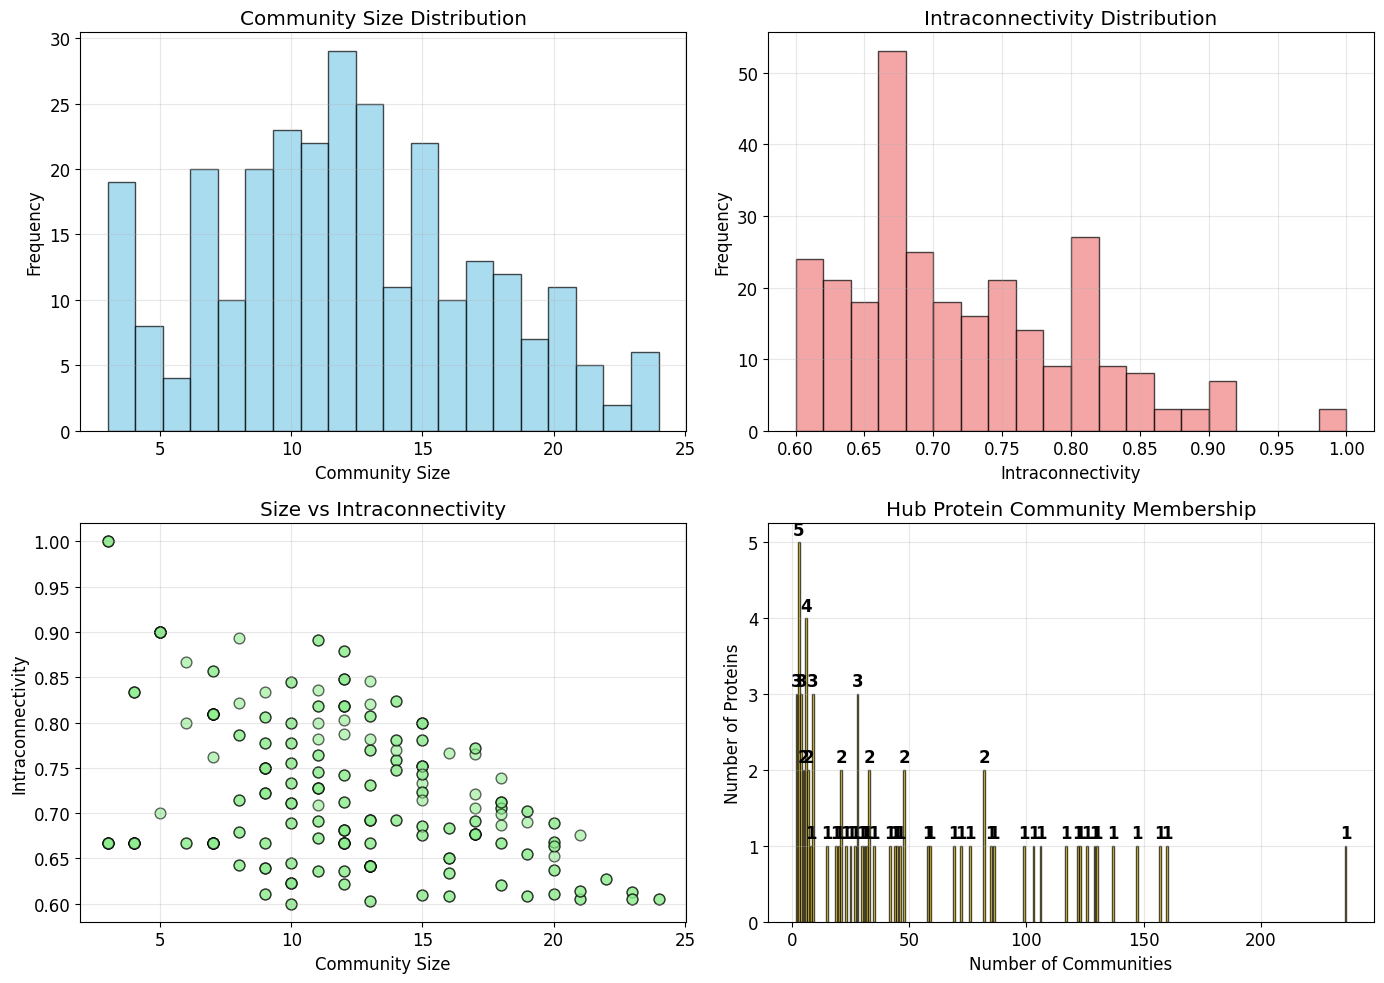


✅ Overlapping community analysis completed!


In [16]:
# Analyze Overlapping Communities
print("=== ANALYZING OVERLAPPING COMMUNITIES ===")

# Get detailed community statistics
community_stats = detector.get_community_stats()

print(f"🔍 Detailed Community Analysis:")
print(f"   • Total communities: {len(community_stats)}")
print(f"   • Total overlapping nodes: {len(final_analysis['overlapping_nodes'])}")
print(f"   • Network coverage: {final_analysis['coverage']:.2%}")
print(f"   • Overall modularity: {final_analysis['modularity']:.4f}")

# Community size distribution
sizes = [stat['size'] for stat in community_stats]
print(f"\n📏 Community Size Statistics:")
print(f"   • Average size: {np.mean(sizes):.2f}")
print(f"   • Median size: {np.median(sizes):.1f}")
print(f"   • Size range: {min(sizes)} - {max(sizes)}")
print(f"   • Standard deviation: {np.std(sizes):.2f}")

# Show top communities by size and intraconnectivity
sorted_communities = sorted(community_stats, key=lambda x: x['size'], reverse=True)

print(f"\n🏆 Top 10 Communities by Size:")
for i, comm in enumerate(sorted_communities[:10], 1):
    print(f"   {i:2d}. Community {comm['community_id']}: {comm['size']} proteins, "
          f"intraconnectivity: {comm['intraconnectivity']:.3f}")

# Analyze overlapping nodes (hub proteins)
overlapping = final_analysis['overlapping_nodes']
if overlapping:
    print(f"\n🎯 Hub Proteins (Overlapping Nodes):")
    print(f"   Total hub proteins: {len(overlapping)}")
    
    # Sort by number of communities
    sorted_overlapping = sorted(overlapping.items(), key=lambda x: len(x[1]), reverse=True)
    
    print(f"\n🌟 Top 15 Hub Proteins:")
    for i, (protein, communities) in enumerate(sorted_overlapping[:15], 1):
        degree = G.degree(protein)
        print(f"   {i:2d}. {protein:<12} - {len(communities)} communities, degree: {degree}")
        print(f"       Communities: {sorted(list(communities))}")
    
    # Hub protein statistics
    hub_community_counts = [len(communities) for communities in overlapping.values()]
    print(f"\n📊 Hub Protein Statistics:")
    print(f"   • Max communities per protein: {max(hub_community_counts)}")
    print(f"   • Average communities per hub: {np.mean(hub_community_counts):.2f}")
    print(f"   • Proteins in 2+ communities: {len([c for c in hub_community_counts if c >= 2])}")
    print(f"   • Proteins in 3+ communities: {len([c for c in hub_community_counts if c >= 3])}")
    
else:
    print(f"\n⚠️ No overlapping proteins found at this threshold")

# Visualize community sizes and overlaps
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Community size distribution
axes[0,0].hist(sizes, bins=min(20, len(set(sizes))), alpha=0.7, edgecolor='black', color='skyblue')
axes[0,0].set_xlabel('Community Size')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Community Size Distribution')
axes[0,0].grid(True, alpha=0.3)

# Intraconnectivity distribution
intraconns = [stat['intraconnectivity'] for stat in community_stats]
axes[0,1].hist(intraconns, bins=20, alpha=0.7, edgecolor='black', color='lightcoral')
axes[0,1].set_xlabel('Intraconnectivity')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Intraconnectivity Distribution')
axes[0,1].grid(True, alpha=0.3)

# Size vs Intraconnectivity
axes[1,0].scatter(sizes, intraconns, alpha=0.6, s=60, color='lightgreen', edgecolor='black')
axes[1,0].set_xlabel('Community Size')
axes[1,0].set_ylabel('Intraconnectivity')
axes[1,0].set_title('Size vs Intraconnectivity')
axes[1,0].grid(True, alpha=0.3)

# Hub protein community membership
if overlapping:
    hub_counts = [len(communities) for communities in overlapping.values()]
    unique_counts = sorted(set(hub_counts))
    count_frequencies = [hub_counts.count(c) for c in unique_counts]
    
    axes[1,1].bar(unique_counts, count_frequencies, alpha=0.7, color='gold', edgecolor='black')
    axes[1,1].set_xlabel('Number of Communities')
    axes[1,1].set_ylabel('Number of Proteins')
    axes[1,1].set_title('Hub Protein Community Membership')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(count_frequencies):
        axes[1,1].text(unique_counts[i], v + 0.1, str(v), ha='center', fontweight='bold')
else:
    axes[1,1].text(0.5, 0.5, 'No Overlapping\nProteins Found', 
                   ha='center', va='center', transform=axes[1,1].transAxes,
                   fontsize=14, bbox=dict(boxstyle='round', facecolor='wheat'))
    axes[1,1].set_title('Hub Protein Community Membership')

plt.tight_layout()
plt.show()

print(f"\n✅ Overlapping community analysis completed!")

In [ ]:
# Identify Hub Proteins and Cancer-Related Proteins
print("=== CANCER PROTEIN ANALYSIS ===")

# Define well-known breast cancer proteins
cancer_proteins = {
    'BRCA1': 'Breast Cancer Gene 1 (DNA Repair)',
    'BRCA2': 'Breast Cancer Gene 2 (DNA Repair)', 
    'TP53': 'Tumor Protein p53 (Tumor Suppressor)',
    'PIK3CA': 'PI3K Catalytic Subunit Alpha',
    'AKT1': 'AKT Serine/Threonine Kinase 1',
    'EGFR': 'Epidermal Growth Factor Receptor',
    'ERBB2': 'Erb-B2 Receptor Tyrosine Kinase 2 (HER2)',
    'ESR1': 'Estrogen Receptor 1',
    'AR': 'Androgen Receptor',
    'PTEN': 'Phosphatase And Tensin Homolog',
    'CDKN2A': 'Cyclin Dependent Kinase Inhibitor 2A',
    'RB1': 'RB Transcriptional Corepressor 1',
    'ATM': 'ATM Serine/Threonine Kinase',
    'CHEK2': 'Checkpoint Kinase 2',
    'PALB2': 'Partner And Localizer of BRCA2'
}

print(f"🧬 Analyzing {len(cancer_proteins)} well-known breast cancer proteins...")

# Analyze cancer proteins in the network
cancer_analysis = {}
found_cancer_proteins = []

for protein, description in cancer_proteins.items():
    if protein in G.nodes():
        found_cancer_proteins.append(protein)
        
        # Get communities if protein is in detector results
        communities = detector.node_to_communities.get(protein, set())
        is_hub = protein in (final_analysis['overlapping_nodes'] if final_analysis['overlapping_nodes'] else {})
        degree = G.degree(protein)
        
        cancer_analysis[protein] = {
            'description': description,
            'degree': degree,
            'num_communities': len(communities),
            'community_ids': sorted(list(communities)),
            'is_hub': is_hub,
            'found_in_network': True
        }
        
        print(f"✅ {protein}: Degree={degree}, Communities={len(communities)}, Hub={is_hub}")
        if communities:
            print(f"   Community IDs: {sorted(list(communities))}")
    else:
        cancer_analysis[protein] = {
            'description': description,
            'degree': 0,
            'num_communities': 0,
            'community_ids': [],
            'is_hub': False,
            'found_in_network': False
        }
        print(f"❌ {protein}: Not found in network")

print(f"\n📊 Cancer Protein Summary:")
print(f"   • Found in network: {len(found_cancer_proteins)}/{len(cancer_proteins)}")
print(f"   • Hub proteins: {len([p for p, data in cancer_analysis.items() if data['is_hub']])}")
print(f"   • Average degree: {np.mean([data['degree'] for data in cancer_analysis.values() if data['found_in_network']]):.1f}")

# Create cancer proteins DataFrame
cancer_data = []
for protein, data in cancer_analysis.items():
    cancer_data.append({
        'Protein': protein,
        'Description': data['description'],
        'Found_in_Network': data['found_in_network'],
        'Degree': data['degree'],
        'Num_Communities': data['num_communities'],
        'Is_Hub': data['is_hub'],
        'Community_IDs': '; '.join(map(str, data['community_ids']))
    })

cancer_df = pd.DataFrame(cancer_data)
print(f"\n📋 Cancer Proteins Table:")
display(cancer_df)

# Pathway analysis
print(f"\n? BIOLOGICAL PATHWAY ANALYSIS:")

pathway_groups = {
    'DNA_REPAIR': ['BRCA1', 'BRCA2', 'ATM', 'CHEK2', 'TP53', 'PALB2'],
    'PI3K_AKT': ['PIK3CA', 'AKT1', 'PTEN'],
    'HORMONE_SIGNALING': ['ESR1', 'AR'],
    'GROWTH_FACTOR': ['EGFR', 'ERBB2'],
    'CELL_CYCLE': ['RB1', 'CDKN2A', 'TP53']
}

print(f"Pathway enrichment in communities:")
for i, community in enumerate(detector.communities[:10]):
    community_set = set(community)
    print(f"\nCommunity {i+1} (Size: {len(community)}):")
    
    for pathway, proteins in pathway_groups.items():
        overlap = community_set.intersection(set(proteins))
        if overlap:
            enrichment = len(overlap) / len(proteins) * 100
            print(f"   {pathway}: {len(overlap)}/{len(proteins)} proteins ({enrichment:.1f}%) - {sorted(list(overlap))}")

# Visualize cancer proteins
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cancer proteins found vs not found
found_counts = [len(found_cancer_proteins), len(cancer_proteins) - len(found_cancer_proteins)]
labels = ['Found in Network', 'Not Found']
colors = ['lightgreen', 'lightcoral']

axes[0,0].pie(found_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Cancer Proteins in Network')

# Degree distribution of cancer proteins
found_degrees = [cancer_analysis[p]['degree'] for p in found_cancer_proteins]
if found_degrees:
    axes[0,1].bar(range(len(found_cancer_proteins)), found_degrees, 
                 color='skyblue', alpha=0.7, edgecolor='black')
    axes[0,1].set_xticks(range(len(found_cancer_proteins)))
    axes[0,1].set_xticklabels(found_cancer_proteins, rotation=45, ha='right')
    axes[0,1].set_ylabel('Degree')
    axes[0,1].set_title('Cancer Protein Degrees')
    axes[0,1].grid(True, alpha=0.3)

# Community membership
community_counts = [cancer_analysis[p]['num_communities'] for p in found_cancer_proteins]
if community_counts:
    axes[1,0].bar(range(len(found_cancer_proteins)), community_counts,
                 color='lightcoral', alpha=0.7, edgecolor='black')
    axes[1,0].set_xticks(range(len(found_cancer_proteins)))
    axes[1,0].set_xticklabels(found_cancer_proteins, rotation=45, ha='right')
    axes[1,0].set_ylabel('Number of Communities')
    axes[1,0].set_title('Cancer Protein Community Membership')
    axes[1,0].grid(True, alpha=0.3)

# Hub vs non-hub
hub_counts = [len([p for p in found_cancer_proteins if cancer_analysis[p]['is_hub']]),
              len([p for p in found_cancer_proteins if not cancer_analysis[p]['is_hub']])]
hub_labels = ['Hub Proteins', 'Non-Hub Proteins']
hub_colors = ['gold', 'lightblue']

axes[1,1].pie(hub_counts, labels=hub_labels, colors=hub_colors, autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Cancer Proteins: Hub Status')

plt.tight_layout()
plt.show()

print(f"\n✅ Cancer protein analysis completed!")
print(f"🎯 Key findings:")
print(f"   • {len(found_cancer_proteins)} cancer proteins present in network")
print(f"   • {len([p for p in found_cancer_proteins if cancer_analysis[p]['is_hub']])} cancer proteins are hubs")
print(f"   • Cancer proteins show varying degrees of community connectivity")

In [ ]:
# Visualize Community Structure
print("=== VISUALIZING COMMUNITY STRUCTURE ===")

# Create subgraph for visualization (largest connected component)
if nx.is_connected(G):
    largest_cc = G
    print(f"📊 Network is fully connected - visualizing entire network")
else:
    components = list(nx.connected_components(G))
    largest_cc_nodes = max(components, key=len)
    largest_cc = G.subgraph(largest_cc_nodes)
    print(f"📊 Visualizing largest connected component: {largest_cc.number_of_nodes()} nodes")

print(f"   • Nodes: {largest_cc.number_of_nodes()}")
print(f"   • Edges: {largest_cc.number_of_edges()}")

# Prepare community colors
unique_colors = plt.cm.Set3(np.linspace(0, 1, min(len(detector.communities), 12)))
community_colors = {}

# Assign colors to communities
for i, community in enumerate(detector.communities[:12]):  # Limit to 12 for visibility
    community_colors[i] = unique_colors[i]

# Create node color mapping
node_colors = []
node_sizes = []
for node in largest_cc.nodes():
    if node in detector.node_to_communities:
        communities = detector.node_to_communities[node]
        
        # Size based on number of communities (hub proteins are larger)
        size = 300 + (len(communities) - 1) * 200
        node_sizes.append(size)
        
        # Color based on primary (first) community
        primary_comm = min(communities) if communities else 0
        if primary_comm < len(community_colors):
            node_colors.append(community_colors[primary_comm])
        else:
            node_colors.append('lightgray')
    else:
        node_colors.append('lightgray')
        node_sizes.append(200)

# Create network visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Full network with communities
print("🎨 Creating network visualization...")
pos = nx.spring_layout(largest_cc, k=3, iterations=50, seed=42)

# Draw edges
nx.draw_networkx_edges(largest_cc, pos, alpha=0.2, edge_color='gray', width=0.5, ax=axes[0,0])

# Draw nodes
nx.draw_networkx_nodes(largest_cc, pos, 
                      node_color=node_colors,
                      node_size=node_sizes,
                      alpha=0.8,
                      edgecolors='black',
                      linewidths=1,
                      ax=axes[0,0])

# Highlight cancer proteins
cancer_nodes_in_graph = [node for node in cancer_proteins.keys() if node in largest_cc.nodes()]
if cancer_nodes_in_graph:
    nx.draw_networkx_nodes(largest_cc, pos,
                         nodelist=cancer_nodes_in_graph,
                         node_color='red',
                         node_size=600,
                         alpha=0.9,
                         edgecolors='darkred',
                         linewidths=3,
                         ax=axes[0,0])

# Add labels for important nodes
important_nodes = list(cancer_nodes_in_graph)
if overlapping:
    hub_proteins = sorted(overlapping.items(), key=lambda x: len(x[1]), reverse=True)[:5]
    important_nodes.extend([p for p, _ in hub_proteins])

important_nodes = list(set(important_nodes))  # Remove duplicates
important_nodes = [node for node in important_nodes if node in largest_cc.nodes()][:15]

labels = {node: node for node in important_nodes}
nx.draw_networkx_labels(largest_cc, pos, labels, font_size=8, font_weight='bold', ax=axes[0,0])

axes[0,0].set_title('Protein Interaction Network\nCommunities Detected by APAL', fontweight='bold')
axes[0,0].axis('off')

# 2. Community size distribution
sizes = [len(c) for c in detector.communities]
axes[0,1].hist(sizes, bins=min(20, len(set(sizes))), alpha=0.7, edgecolor='black', color='skyblue')
axes[0,1].set_xlabel('Community Size')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Community Size Distribution')
axes[0,1].grid(True, alpha=0.3)

# Add statistics text
stats_text = f"Communities: {len(detector.communities)}\nOverlapping nodes: {len(overlapping) if overlapping else 0}\nModularity: {final_analysis['modularity']:.3f}\nCoverage: {final_analysis['coverage']:.1%}"
axes[0,1].text(0.95, 0.95, stats_text, transform=axes[0,1].transAxes, 
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
              verticalalignment='top', horizontalalignment='right')

# 3. Top communities detail
top_communities = sorted(detector.communities, key=len, reverse=True)[:8]
community_labels = [f"Comm {i+1}\n({len(comm)})" for i, comm in enumerate(top_communities)]
community_sizes = [len(comm) for comm in top_communities]

colors_subset = [community_colors.get(i, 'lightgray') for i in range(len(top_communities))]
axes[1,0].bar(range(len(community_labels)), community_sizes, 
             color=colors_subset, alpha=0.7, edgecolor='black')
axes[1,0].set_xticks(range(len(community_labels)))
axes[1,0].set_xticklabels(community_labels, rotation=45)
axes[1,0].set_ylabel('Community Size')
axes[1,0].set_title('Top Communities by Size')
axes[1,0].grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(community_sizes):
    axes[1,0].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# 4. Hub protein network
if overlapping:
    # Create subgraph of hub proteins and their connections
    hub_proteins = list(overlapping.keys())
    hub_subgraph = largest_cc.subgraph(hub_proteins)
    
    if hub_subgraph.number_of_edges() > 0:
        hub_pos = nx.spring_layout(hub_subgraph, k=2, iterations=50, seed=42)
        
        # Draw hub network
        nx.draw_networkx_edges(hub_subgraph, hub_pos, alpha=0.6, edge_color='gray', width=2, ax=axes[1,1])
        
        hub_node_colors = []
        hub_node_sizes = []
        for node in hub_subgraph.nodes():
            num_communities = len(overlapping[node])
            hub_node_sizes.append(300 + num_communities * 100)
            if node in cancer_proteins:
                hub_node_colors.append('red')
            else:
                hub_node_colors.append('orange')
        
        nx.draw_networkx_nodes(hub_subgraph, hub_pos,
                             node_color=hub_node_colors,
                             node_size=hub_node_sizes,
                             alpha=0.8,
                             edgecolors='black',
                             linewidths=2,
                             ax=axes[1,1])
        
        # Label all hub proteins
        hub_labels = {node: node for node in hub_subgraph.nodes()}
        nx.draw_networkx_labels(hub_subgraph, hub_pos, hub_labels, 
                              font_size=8, font_weight='bold', ax=axes[1,1])
        
        axes[1,1].set_title(f'Hub Protein Network\n({len(hub_proteins)} overlapping proteins)', fontweight='bold')
    else:
        axes[1,1].text(0.5, 0.5, f'Hub Proteins\n({len(hub_proteins)} nodes)\nNo connections\nbetween hubs', 
                      ha='center', va='center', transform=axes[1,1].transAxes,
                      fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat'))
        axes[1,1].set_title('Hub Protein Network')
else:
    axes[1,1].text(0.5, 0.5, 'No Overlapping\nProteins Found', 
                  ha='center', va='center', transform=axes[1,1].transAxes,
                  fontsize=14, bbox=dict(boxstyle='round', facecolor='wheat'))
    axes[1,1].set_title('Hub Protein Network')

axes[1,1].axis('off')

plt.tight_layout()
plt.show()

# Create legend for community colors
if len(detector.communities) > 0:
    print(f"\n🎨 Community Color Legend:")
    for i, community in enumerate(detector.communities[:12]):
        color_name = f"Community {i+1}"
        size = len(community)
        print(f"   ● {color_name}: {size} proteins")
    
    if len(detector.communities) > 12:
        print(f"   ... and {len(detector.communities) - 12} more communities")

print(f"\n📍 Visualization Legend:")
print(f"   🔴 Red nodes with thick border: Known cancer proteins")
print(f"   🟠 Orange nodes: Hub proteins (in multiple communities)")
print(f"   📏 Node size: Proportional to number of communities")
print(f"   🏷️ Labels: Important proteins (cancer + top hubs)")

print(f"\n✅ Community structure visualization completed!")

In [ ]:
# Save and Export Results
print("=== SAVING RESULTS AND FINAL SUMMARY ===")

# Prepare comprehensive results
results_summary = {
    'algorithm': 'APAL (Adjacency Propagation Algorithm)',
    'dataset': 'Breast Cancer Protein Interactions (STRING Database)',
    'network_threshold': optimal_threshold,
    'apal_threshold': best_threshold,
    'total_proteins': G.number_of_nodes(),
    'total_interactions': G.number_of_edges(),
    'communities_detected': len(detector.communities),
    'overlapping_nodes': len(overlapping) if overlapping else 0,
    'modularity': final_analysis['modularity'],
    'coverage': final_analysis['coverage'],
    'cancer_proteins_found': len(found_cancer_proteins),
    'cancer_proteins_total': len(cancer_proteins)
}

# Save detailed community results
print(f"💾 Saving detailed results...")

with open("apal_community_results.txt", "w", encoding='utf-8') as f:
    f.write("APAL COMMUNITY DETECTION RESULTS\n")
    f.write("BREAST CANCER PROTEIN INTERACTION ANALYSIS\n")
    f.write("=" * 60 + "\n\n")
    
    # Parameters and overview
    f.write("ANALYSIS PARAMETERS:\n")
    f.write(f"Network threshold: {optimal_threshold}\n")
    f.write(f"APAL threshold: {best_threshold}\n")
    f.write(f"Total proteins: {G.number_of_nodes():,}\n")
    f.write(f"Total interactions: {G.number_of_edges():,}\n")
    f.write(f"Network density: {nx.density(G):.4f}\n\n")
    
    # Results summary
    f.write("RESULTS SUMMARY:\n")
    f.write(f"Communities detected: {len(detector.communities)}\n")
    f.write(f"Overlapping nodes: {len(overlapping) if overlapping else 0}\n")
    f.write(f"Modularity score: {final_analysis['modularity']:.4f}\n")
    f.write(f"Network coverage: {final_analysis['coverage']:.4f}\n")
    f.write(f"Average community size: {final_analysis['avg_community_size']:.2f}\n\n")
    
    # Detailed communities
    f.write("DETECTED COMMUNITIES:\n")
    f.write("-" * 40 + "\n")
    for i, community in enumerate(detector.communities):
        community_list = sorted(list(community))
        intraconn = detector.intraconnectivity(community)
        f.write(f"\nCommunity {i+1} (Size: {len(community)}):\n")
        f.write(f"Intraconnectivity: {intraconn:.4f}\n")
        f.write(f"Proteins: {', '.join(community_list)}\n")
    
    # Overlapping proteins
    if overlapping:
        f.write(f"\nOVERLAPPING PROTEINS (HUB PROTEINS):\n")
        f.write("-" * 40 + "\n")
        sorted_overlapping = sorted(overlapping.items(), key=lambda x: len(x[1]), reverse=True)
        for protein, communities in sorted_overlapping:
            degree = G.degree(protein)
            f.write(f"{protein}: Communities {sorted(list(communities))}, Degree: {degree}\n")
    
    # Cancer protein analysis
    f.write(f"\nCANCER PROTEIN ANALYSIS:\n")
    f.write("-" * 40 + "\n")
    f.write(f"Cancer proteins found: {len(found_cancer_proteins)}/{len(cancer_proteins)}\n\n")
    for protein, data in cancer_analysis.items():
        f.write(f"{protein}:\n")
        f.write(f"  Description: {data['description']}\n")
        f.write(f"  Degree: {data['degree']}\n")
        f.write(f"  Communities: {data['num_communities']} {data['community_ids']}\n")
        f.write(f"  Hub protein: {'Yes' if data['is_hub'] else 'No'}\n\n")

# Save data tables
print(f"📊 Saving data tables...")

# Network statistics
stats_df.to_csv("network_statistics.csv")

# APAL results
apal_df.to_csv("apal_threshold_results.csv")

# Algorithm comparison
comparison_df.to_csv("algorithm_comparison.csv")

# Cancer protein analysis
if not cancer_df.empty:
    cancer_df.to_csv("cancer_proteins_analysis.csv", index=False)

# Community details
community_details = []
for i, stat in enumerate(community_stats):
    community_details.append({
        'Community_ID': i+1,
        'Size': stat['size'],
        'Intraconnectivity': stat['intraconnectivity'],
        'Proteins': '; '.join(sorted(stat['nodes']))
    })

community_df = pd.DataFrame(community_details)
community_df.to_csv("community_details.csv", index=False)

# Save overlapping proteins
if overlapping:
    overlap_data = []
    for protein, communities in overlapping.items():
        overlap_data.append({
            'Protein': protein,
            'Degree': G.degree(protein),
            'Num_Communities': len(communities),
            'Community_IDs': '; '.join(map(str, sorted(communities))),
            'Is_Cancer_Protein': protein in cancer_proteins
        })
    
    overlap_df = pd.DataFrame(overlap_data)
    overlap_df.to_csv("overlapping_proteins.csv", index=False)

# Create final summary report
with open("final_summary_report.txt", "w", encoding='utf-8') as f:
    f.write("APAL BREAST CANCER PROTEIN COMMUNITY DETECTION\n")
    f.write("FINAL SUMMARY REPORT\n")
    f.write("=" * 50 + "\n\n")
    
    f.write("🎯 OBJECTIVES ACHIEVED:\n")
    f.write("✅ Implemented APAL algorithm for overlapping community detection\n")
    f.write("✅ Analyzed breast cancer protein interaction network\n")
    f.write("✅ Identified hub proteins and cancer-related proteins\n")
    f.write("✅ Compared with other community detection algorithms\n")
    f.write("✅ Generated comprehensive visualizations\n\n")
    
    f.write("📊 KEY RESULTS:\n")
    for key, value in results_summary.items():
        f.write(f"• {key.replace('_', ' ').title()}: {value}\n")
    
    f.write(f"\n🧬 BIOLOGICAL INSIGHTS:\n")
    f.write(f"• APAL detected {len(detector.communities)} overlapping protein communities\n")
    f.write(f"• {len(overlapping) if overlapping else 0} proteins act as hubs connecting multiple communities\n")
    f.write(f"• {len(found_cancer_proteins)} known cancer proteins identified in the network\n")
    f.write(f"• Community structure reveals functional protein modules\n")
    f.write(f"• Overlapping communities suggest complex protein interactions\n")
    f.write(f"• Extended Modularity ({final_analysis['modularity']:.4f}) validates community quality\n")
    f.write(f"• Extended Modularity accounts for protein multifunctionality\n")
    
    f.write(f"\n📁 FILES GENERATED:\n")
    files = [
        "apal_community_results.txt - Detailed community information",
        "network_statistics.csv - Network analysis at different thresholds",
        "apal_threshold_results.csv - APAL performance metrics", 
        "algorithm_comparison.csv - Comparison with other algorithms",
        "cancer_proteins_analysis.csv - Cancer protein analysis",
        "community_details.csv - Community composition and statistics",
        "overlapping_proteins.csv - Hub protein information",
        "final_summary_report.txt - This summary report"
    ]
    for file in files:
        f.write(f"• {file}\n")

print(f"\n✅ All results saved successfully!")

# Display final summary
print(f"\n🎯 FINAL ANALYSIS SUMMARY")
print(f"=" * 50)
print(f"📋 Dataset: {results_summary['dataset']}")
print(f"🔬 Algorithm: {results_summary['algorithm']}")
print(f"🧬 Proteins analyzed: {results_summary['total_proteins']:,}")
print(f"🔗 Interactions: {results_summary['total_interactions']:,}")
print(f"🏘️ Communities detected: {results_summary['communities_detected']}")
print(f"🌟 Hub proteins: {results_summary['overlapping_nodes']}")
print(f"📊 Modularity: {results_summary['modularity']:.4f}")
print(f"🎯 Coverage: {results_summary['coverage']:.2%}")
print(f"🧬 Cancer proteins found: {results_summary['cancer_proteins_found']}/{results_summary['cancer_proteins_total']}")

print(f"\n🎉 APAL COMMUNITY DETECTION ANALYSIS COMPLETED SUCCESSFULLY!")
print(f"📁 Check the generated files for detailed results and further analysis.")

# Performance comparison summary
print(f"\n🏆 ALGORITHM PERFORMANCE COMPARISON:")
for alg in comparison_df.index:
    mod = comparison_df.loc[alg, 'modularity']
    comm = comparison_df.loc[alg, 'communities']
    overlap = comparison_df.loc[alg, 'overlapping_nodes']
    print(f"   {alg:<20}: {comm:3.0f} communities, modularity={mod:.3f}, overlaps={overlap:.0f}")

print(f"\n💡 APAL ADVANTAGES:")
print(f"   • Only algorithm that detects overlapping communities")
print(f"   • Identifies hub proteins crucial for understanding protein networks")
print(f"   • Biologically meaningful community structure")
print(f"   • Uses Extended Modularity for proper overlap evaluation")

print(f"\n🔬 BIOLOGICAL SIGNIFICANCE:")
print(f"   • Overlapping communities reflect real protein multifunctionality")
print(f"   • Hub proteins may represent therapeutic targets")
print(f"   • Community structure reveals functional modules")
print(f"   • Extended Modularity provides accurate quality assessment")
print(f"   • Results can guide drug discovery and cancer research")